## import

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)

In [ ]:
cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## unzip and split

In [ ]:
!unzip /content/drive/MyDrive/image-segmentation/dataset/BPRW.zip

In [ ]:
#!rm -r /content/__MACOSX
#!mv /content/BPRW-fake /content/BPRW
#!rm -r /content/BPRW
#!rm -r /content/Development_Dataset_Sub
!rm -r /content/BPRW/Training/Splits

In [ ]:
def filter(file_list, Mais=True, Haricot=True, Bipbip=True, Pead=True, Roseau=True, Weedelec=True):
  file_list = [k for k in file_list if not ('.' in k)] # remove hidden files
  # WARNING if any files has '.' in the name it will be removed but this is not
  #         the case for our dataset
  if not Mais:
    file_list = [k for k in file_list if not ('mais' in k)]
  if not Haricot:
    file_list = [k for k in file_list if not ('haricot' in k)]
  if not Bipbip:
    file_list = [k for k in file_list if not ('Bipbip' in k)]
  if not Pead:
    file_list = [k for k in file_list if not ('Pead' in k)]
  if not Roseau:
    file_list = [k for k in file_list if not ('Roseau' in k)]
  if not Weedelec:
    file_list = [k for k in file_list if not ('Weedelec' in k)]
  
  return file_list

In [ ]:
# create split files
import re
import math
import random

os.chdir('/content/BPRW/Training')
#os.chdir(os.path.join(os.getcwd(), 'Haricot')) # change to change dataset
cwd = os.getcwd()
dir = os.path.join(cwd, 'Images')
file_list = os.listdir(dir)

for i, file_name in enumerate(file_list):
  file_list[i] = re.sub('.jpg', '', file_name)

file_list = filter(file_list, Mais=True, Haricot=True, Bipbip=True, Pead=False, Roseau=False, Weedelec=False)

random.seed(SEED)
random.shuffle(file_list)

valid_cut = .2
valid_files = file_list[math.floor(len(file_list)*(1-valid_cut)):len(file_list)]
train_files = file_list[0:math.floor(len(file_list)*(1-valid_cut))]

split_dir = os.path.join(cwd, 'Splits')
if not os.path.exists(split_dir):
  os.makedirs(split_dir)

with open("Splits/training.txt","w+") as traintxt:
  traintxt.writelines(["%s\n" % el  for el in train_files])

with open("Splits/validation.txt","w+") as validtxt:
  validtxt.writelines(["%s\n" % el  for el in valid_files])

os.chdir('/content')
cwd = os.getcwd()

## prepare dataset

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
from PIL import Image

# img_h = 224
# img_w = 224

img_h = 384
img_w = 384

mask_h = int(3456/2)
mask_w = int(5184/2)

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(
    self, dataset_dir,
    which_subset,
    img_generator=None,
    mask_generator=None, 
    preprocessing_function=None,
    out_shape=[224,224] 
  ):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'training.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'validation.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.jpg'))
    mask = Image.open(os.path.join(self.dataset_dir, 'Masks/', curr_filename + '.png'))


    # Resize image and mask
    if self.which_subset == 'training':
      img = img.resize(self.out_shape)
      mask = mask.resize(self.out_shape, resample=Image.NEAREST)

    # Used only on dataset different from Bipbip
    if self.which_subset == 'validation':
      img = img.resize((mask_w, mask_h))
      mask = mask.resize((mask_w, mask_h), resample=Image.NEAREST)
    #else:
     # img = img.resize((1024,768))  
     # mask = img.resize((1024,768))  
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0 #previous first element 216
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    mask_arr = new_mask_arr

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
os.path.join(cwd, "Development_Dataset_Sub")

'/content/Development_Dataset_Sub'

In [ ]:
type(img_data_gen)

tensorflow.python.keras.preprocessing.image.ImageDataGenerator

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 



dataset = CustomDataset("/content/BPRW/Training", 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=None, out_shape=[img_h,img_w] ) #preprocess_input
dataset_valid = CustomDataset('/content/BPRW/Training', 'validation', 
                              preprocessing_function=None, out_shape=[img_h,img_w] )


In [ ]:

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(8) # bs

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([int(mask_h), int(mask_w), 3], [int(mask_h), int(mask_w), 1]))
valid_dataset = valid_dataset.batch(1)

valid_dataset = valid_dataset.repeat()

In [ ]:
!ls /content/VOCDataset

ls: cannot access '/content/VOCDataset': No such file or directory


In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
colors_dict = {}
colors_dict[2] = [255, 0,0]
colors_dict[1] = [255, 255, 255]  # foreground
colors_dict[0] = [0, 0, 0]  # background
iterator = iter(valid_dataset)

## plot

TensorShape([1728, 2592, 3])

[0. 1. 2.]


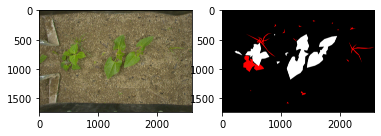

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

augmented_img.shape

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = colors_dict[0]
target_img[np.where(target == 1)] = colors_dict[1]
target_img[np.where(target == 2)] = colors_dict[2]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Convolutional Neural Network (CNN)

### Blocks

In [ ]:
def Conv2dBn(
        filters,
        kernel_size,
        strides=(1, 1),
        padding='valid',
        data_format=None,
        dilation_rate=(1, 1),
        activation=None,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        use_batchnorm=False,
        **kwargs
):
    """Extension of Conv2D layer with batchnorm"""

    conv_name, act_name, bn_name = None, None, None
    block_name = kwargs.pop('name', None)
    #backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if block_name is not None:
        conv_name = block_name + '_conv'

    if block_name is not None and activation is not None:
        act_str = activation.__name__ if callable(activation) else str(activation)
        act_name = block_name + '_' + act_str

    if block_name is not None and use_batchnorm:
        bn_name = block_name + '_bn'

    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    def wrapper(input_tensor):

        x = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=None,
            use_bias=not (use_batchnorm),
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            name=conv_name,
        )(input_tensor)

        if use_batchnorm:
            x = tf.keras.layers.BatchNormalization(axis=bn_axis, name=bn_name)(x)

        if activation:
            x = tf.keras.layers.Activation(activation, name=act_name)(x)

        return x

    return wrapper

def Conv3xxBnReLU(filters, use_batchnorm, name=None):
    #kwargs = get_submodules()
    
    def wrapper(input_tensor):
        return Conv2dBn(
            filters,
            kernel_size=3,
            activation='relu',
            kernel_initializer='he_uniform',
            padding='same',
            use_batchnorm=use_batchnorm,
            name=name#,
            #**kwargs
        )(input_tensor)

    return wrapper


def DoubleConv3x3BnReLU(filters, use_batchnorm, name=None):
    name1, name2 = None, None
    if name is not None:
        name1 = name + 'a'
        name2 = name + 'b'

    def wrapper(input_tensor):
        x = Conv3x3BnReLU(filters, use_batchnorm, name=name1)(input_tensor)
        x = Conv3x3BnReLU(filters, use_batchnorm, name=name2)(x)
        return x

    return wrapper


def FPNBlock(pyramid_filters, stage):
    conv0_name = 'fpn_stage_p{}_pre_conv'.format(stage)
    conv1_name = 'fpn_stage_p{}_conv'.format(stage)
    add_name = 'fpn_stage_p{}_add'.format(stage)
    up_name = 'fpn_stage_p{}_upsampling'.format(stage)

    channels_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    def wrapper(input_tensor, skip):
        # if input tensor channels not equal to pyramid channels
        # we will not be able to sum input tensor and skip
        # so add extra conv layer to transform it
        input_filters = tf.keras.backend.int_shape(input_tensor)[channels_axis]
        if input_filters != pyramid_filters:
            input_tensor = tf.keras.layers.Conv2D(
                filters=pyramid_filters,
                kernel_size=(1, 1),
                kernel_initializer='he_uniform',
                name=conv0_name,
            )(input_tensor)

        skip = tf.keras.layers.Conv2D(
            filters=pyramid_filters,
            kernel_size=(1, 1),
            kernel_initializer='he_uniform',
            name=conv1_name,
        )(skip)

        x = tf.keras.layers.UpSampling2D((2, 2), name=up_name)(input_tensor)
        x = tf.keras.layers.Add(name=add_name)([x, skip])

        return x

    return wrapper

### model

In [ ]:
def create_model(num_classes):
  pyramid_filters = 256
  segmentation_filters = 128
  use_batchnorm = True
  aggregation = 'sum'
  dropout = None
  activation = 'softmax'
  skip_connection_layers = ('block5_conv3', 'block4_conv3', 'block3_conv3', 'block2_conv2', 'block1_conv2')

  input_shape = (None, None, 3)

  model_vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                              weights='imagenet',
                                              include_top=False) 

  freeze_encoder = False # try to freeze
  if freeze_encoder:
    freeze_until = 15
    for layer in model_vgg16.layers[:freeze_until]:
        layer.trainable = False

  input_ = model_vgg16.input
  x = model_vgg16.output

  skips = [model_vgg16.get_layer(name=i).output for i in skip_connection_layers]

  # build FPN pyramid
  p5 = FPNBlock(pyramid_filters, stage=5)(x, skips[0])
  p4 = FPNBlock(pyramid_filters, stage=4)(p5, skips[1])
  p3 = FPNBlock(pyramid_filters, stage=3)(p4, skips[2])
  p2 = FPNBlock(pyramid_filters, stage=2)(p3, skips[3])

  # add segmentation head to each
  s5 = DoubleConv3x3BnReLU(segmentation_filters, use_batchnorm, name='segm_stage5')(p5)
  s4 = DoubleConv3x3BnReLU(segmentation_filters, use_batchnorm, name='segm_stage4')(p4)
  s3 = DoubleConv3x3BnReLU(segmentation_filters, use_batchnorm, name='segm_stage3')(p3)
  s2 = DoubleConv3x3BnReLU(segmentation_filters, use_batchnorm, name='segm_stage2')(p2)

  # upsampling to same resolution
  s5 = tf.keras.layers.UpSampling2D((8, 8), interpolation='nearest', name='upsampling_stage5')(s5)
  s4 = tf.keras.layers.UpSampling2D((4, 4), interpolation='nearest', name='upsampling_stage4')(s4)
  s3 = tf.keras.layers.UpSampling2D((2, 2), interpolation='nearest', name='upsampling_stage3')(s3)

  # aggregating results
  if aggregation == 'sum':
      x = tf.keras.layers.Add(name='aggregation_sum')([s2, s3, s4, s5])
  elif aggregation == 'concat':
      concat_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1
      x = tf.keras.layers.Concatenate(axis=concat_axis, name='aggregation_concat')([s2, s3, s4, s5])
  else:
      raise ValueError('Aggregation parameter should be in ("sum", "concat"), '
                        'got {}'.format(aggregation))

  if dropout:
      x = tf.keras.layers.SpatialDropout2D(dropout, name='pyramid_dropout')(x)

  # final stage
  x = Conv3x3BnReLU(segmentation_filters, use_batchnorm, name='final_stage')(x)
  x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear', name='final_upsampling')(x)

  # model head (define number of output classes)
  x = tf.keras.layers.Conv2D(
      filters=num_classes,
      kernel_size=(3, 3),
      padding='same',
      use_bias=True,
      kernel_initializer='glorot_uniform',
      name='head_conv',
  )(x)
  x = tf.keras.layers.Activation(activation, name=activation)(x)

  # create keras model instance
  model = tf.keras.models.Model(input_, x)
  return model

In [ ]:
num_classes=3
model = create_model(num_classes=3)

## Prepare the model for training

In [ ]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras


In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,2): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
LR = 0.0001

# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
colors_dict[2] = [255, 0,0]
colors_dict[1] = [255, 255, 255]  # foreground
colors_dict[0] = [0, 0, 0]  # background
# set class weights for dice_loss (background: 0; WHITE plants: 1;  RED Weed: 2; )
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 1, 1.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)
#model.compile(optim, focal_loss, metrics)

## Training with callbacks

In [ ]:
model.evaluate(valid_dataset,batch_size = 1, steps = 1)

1/1 [==============================] - 2s 2s/step - loss: 1.2089 - iou_score: 0.0535 - f1-score: 0.0976


[1.2089353799819946, 0.05350935086607933, 0.09764117002487183]

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'Crop_CNN')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
    callbacks.append(es_callback)

model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)/8, #divided by batch size
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
18/18 [==============================] - 78s 4s/step - loss: 0.7435 - iou_score: 0.2128 - f1-score: 0.2887 - val_loss: 1.0830 - val_iou_score: 0.0920 - val_f1-score: 0.1565
Epoch 2/100
 8/18 [============>.................] - ETA: 16s - loss: 0.6288 - iou_score: 0.3136 - f1-score: 0.3513

KeyboardInterrupt: ignored

## Test model

## Compute prediction

In [ ]:
model.load_weights('/content/drive/My Drive/Keras4/Crop_CNN/CNN_Dec18_00-01-31/ckpts/cp_01.ckpt')

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

TensorShape([1728, 2592, 3])

TensorShape([1728, 2592])

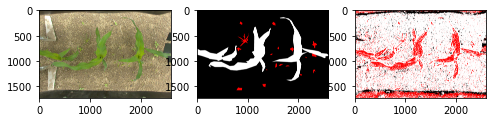

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
#iterator = iter(valid_dataset)
image, target = next(iterator)

image = image[0]
image.shape
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

#out_sigmoid.shape

predicted_class = predicted_class[0, ...]
predicted_class.shape


# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = colors_dict[0]
target_img[np.where(target == 1)] = colors_dict[1]
target_img[np.where(target == 2)] = colors_dict[2]

prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
prediction_img[np.where(predicted_class == 1)] = colors_dict[1]
prediction_img[np.where(predicted_class == 2)] = colors_dict[2]


ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

img = Image.fromarray(np.uint8(prediction_img)).resize((mask_w,mask_h), Image.NEAREST)



fig.canvas.draw()
time.sleep(1)

In [ ]:
!unzip /content/drive/MyDrive/image-segmentation/dataset/Test_Dev.zip

unzip:  cannot find or open /content/drive/MyDrive/image-segmentation/dataset/Test_Dev.zip, /content/drive/MyDrive/image-segmentation/dataset/Test_Dev.zip.zip or /content/drive/MyDrive/image-segmentation/dataset/Test_Dev.zip.ZIP.


In [ ]:
import os
import json
import numpy as np
from PIL import Image


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [ ]:
data_folders = next(os.walk("/content/BPRW/Test_Dev/"))[1]
data_folders
for ds in data_folders:
  subset_folders = next(os.walk("/content/BPRW/Test_Dev/"+ds))[1]
  subset_folders
  for sb in subset_folders:
    test_filenames = next(os.walk("/content/BPRW/Test_Dev/"+ds+"/"+sb+"/Images"))[2]
    #test_filenames
    #for name in test_filenames:
    #  name
 

In [ ]:

    # The submission file will be a zip file containing the a
    # submission.json file.

    # It must have the following structure:

    # - image name (without any extension, e.g., png, jpg, etc.)
    #   - shape: shape of the original image as list [Height, Width]
    #   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
    #   - crop: crop of the original image. One in {'Haricot', 'Mais'}
    #   - segmentation: prediction (as a dict)
    #     - crop: RLE encoded crop segmentation (no weed)
    #     - weed: RLE encoded weed segmentation (no crop)

    # Please refer to the folder structure of the given dataset to fill
    # the team and crop keys.

    # EXAMPLE:

    # Suppose that the numpy array generated with the
    # 'read_mask_example.py' script is the output of your segmentation model.
    # In addition, suppose that the team and crop of the segmented image
    # are 'Bipbip' and 'Haricot', respectively.
    # Then, in the following an example of submission file.
  
    #loop over test images
data_folders = next(os.walk("/content/BPRW/Test_Dev/"))[1]

submission_dict = {}

for ds in data_folders:
  subset_folders = next(os.walk("/content/BPRW/Test_Dev/"+ds))[1]
  for sb in subset_folders:

    test_filenames = next(os.walk("/content/BPRW/Test_Dev/"+ds+"/"+sb+"/Images"))[2]
    #test_filenames[:1]

    for image_name in test_filenames:

      img_name = image_name.split(".")[0]

      # load mask <- HERE you should have your segmentation model instead
      if (ds == "Roseau"):
        image = Image.open("/content/BPRW/Test_Dev/"+ds+"/"+sb+"/Images/"+image_name).convert('RGB')
        width, height = image.size
        image.size
        #image = image.resize((int(width/2), int(height/2)))
        #image
        # ------- padding image in order to work with all dataset ----
        # Not working now
        pre = np.array(image)
        pre.shape
        #break
        if(height % 2 != 0 and width % 2 != 0):
          pre =np.pad(pre, ((1,1), (1,1), (0, 0)), 'constant')
        if(height % 2 != 0):
          #pad width  
          pre = np.pad(pre, ((0,0), (1,1), (0, 0)), 'constant')
        if(width % 2 != 0):
         pre =np.pad(pre, ((1,1), (0,0), (0, 0)), 'constant')  

        pre = Image.fromarray(np.uint8(pre)).resize((int(width/2), int(height/2)))

        #--- end padding 

        image_array = tf.cast(tf.expand_dims(np.array(pre), 0), tf.float32) #substitute pre with image
        
       # image_array
        #image_array = preprocess_input(image_array)
        out_sigmoid = model.predict(x = image_array)

        predicted_class = tf.argmax(out_sigmoid, -1)
      

        predicted_class = predicted_class[0, ...]
        prediction_img = np.zeros([int(height/2),int(width/2), 3])
        

        

        prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
        prediction_img[np.where(predicted_class == 1)] = colors_dict[1]
        prediction_img[np.where(predicted_class == 2)] = colors_dict[2]

        
        img = Image.fromarray(np.uint8(prediction_img)).resize((width, height), Image.NEAREST)
        #img
        mask_arr = np.array(img)

        new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

          # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
        new_mask_arr[np.where(np.all(mask_arr == colors_dict[0], axis=-1))] = 0
        new_mask_arr[np.where(np.all(mask_arr == colors_dict[1], axis=-1))] = 1
        new_mask_arr[np.where(np.all(mask_arr == colors_dict[2], axis=-1))] = 2
       # predicted_class
        mask_arr = new_mask_arr
      else:
        mask_arr = np.zeros([mask_w, mask_h, 3]) 
      #image_array
      #mask_arr
      

      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = mask_arr.shape
      submission_dict[img_name]['team'] = ds
      submission_dict[img_name]['crop'] = sb
      submission_dict[img_name]['segmentation'] = {}

          # RLE encoding
          # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
          # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

submission_dict
# Please notice that in this example we have a single prediction.
# For the competition you have to provide segmentation for each of
# the test images.

# Finally, save the results into the submission.json file
with open('/content/submission.json', 'w') as f:
    json.dump(submission_dict, f)
